In [1]:
import pandas as pd

# Define the file path
file_path = r"D:\Dataset\DDos Attack Detection\dataset_sdn.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

      dt  switch       src       dst  pktcount  bytecount  dur   dur_nsec  \
0  11425       1  10.0.0.1  10.0.0.8     45304   48294064  100  716000000   
1  11605       1  10.0.0.1  10.0.0.8    126395  134737070  280  734000000   
2  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
3  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
4  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   

        tot_dur  flows  ...  pktrate  Pairflow  Protocol  port_no   tx_bytes  \
0  1.010000e+11      3  ...      451         0       UDP        3  143928631   
1  2.810000e+11      2  ...      451         0       UDP        4       3842   
2  2.010000e+11      3  ...      451         0       UDP        1       3795   
3  2.010000e+11      3  ...      451         0       UDP        2       3688   
4  2.010000e+11      3  ...      451         0       UDP        3       3413   

  rx_bytes  tx_kbps  rx_kbps  tot_kbps  label  
0     39

In [2]:
print(df.columns)

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'Protocol', 'port_no', 'tx_bytes',
       'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'label'],
      dtype='object')


In [3]:
# Check for duplicate rows
duplicates = df.duplicated()

# Count total duplicates
total_duplicates = duplicates.sum()

# Print results
print(f"Total duplicate rows: {total_duplicates}")

# Display duplicate rows if any exist
if total_duplicates > 0:
    print(df[duplicates])

Total duplicate rows: 5091
          dt  switch        src       dst  pktcount  bytecount  dur  \
13     11425       1   10.0.0.1  10.0.0.8     45304   48294064  100   
15     11425       1   10.0.0.1  10.0.0.8     45304   48294064  100   
30     11425       1   10.0.0.2  10.0.0.8     90333   96294978  200   
34     11425       1   10.0.0.2  10.0.0.8     90333   96294978  200   
40     11425       1   10.0.0.2  10.0.0.8     90333   96294978  200   
...      ...     ...        ...       ...       ...        ...  ...   
33474   3249       8  10.0.0.12  10.0.0.5     88782   94641612  197   
33501   3609       8   10.0.0.3  10.0.0.5    119500  124519000  407   
33512   3609       8   10.0.0.3  10.0.0.5    119500  124519000  407   
33559   3159       8  10.0.0.12  10.0.0.5     48292   51479272  107   
33584   3249       8   10.0.0.3  10.0.0.5     14973   15601866   47   

        dur_nsec       tot_dur  flows  ...  pktrate  Pairflow  Protocol  \
13     716000000  1.010000e+11      3  ...   

In [4]:
# Remove duplicate rows and update the DataFrame
df = df.drop_duplicates()

# Print confirmation
print("Duplicate rows removed. New shape:", df.shape)

Duplicate rows removed. New shape: (99254, 23)


In [5]:
print(df.isnull().sum())

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


Checking if outlier are present in this column than use median else we use mean for filling the missing values

In [6]:
import numpy as np

def check_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return len(outliers) > 0 

# Check for outliers
rx_outliers = check_outliers('rx_kbps')
tot_outliers = check_outliers('tot_kbps')

# Fill missing values safely using .loc[]
df.loc[:, 'rx_kbps'] = df['rx_kbps'].fillna(df['rx_kbps'].median() if rx_outliers else df['rx_kbps'].mean())
df.loc[:, 'tot_kbps'] = df['tot_kbps'].fillna(df['tot_kbps'].median() if tot_outliers else df['tot_kbps'].mean())

# Print results
print(f"Outliers in rx_kbps: {rx_outliers}")
print(f"Outliers in tot_kbps: {tot_outliers}")

Outliers in rx_kbps: True
Outliers in tot_kbps: True


In [7]:
print(df.isnull().sum())

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64


In [8]:
unique_protocols = df['Protocol'].unique()
print(unique_protocols)

['UDP' 'TCP' 'ICMP']


In [9]:
protocol_mapping = {'UDP': 0, 'TCP': 1, 'ICMP': 2}
df['Protocol'] = df['Protocol'].map(protocol_mapping)
print(df['Protocol'].unique())

[0 1 2]


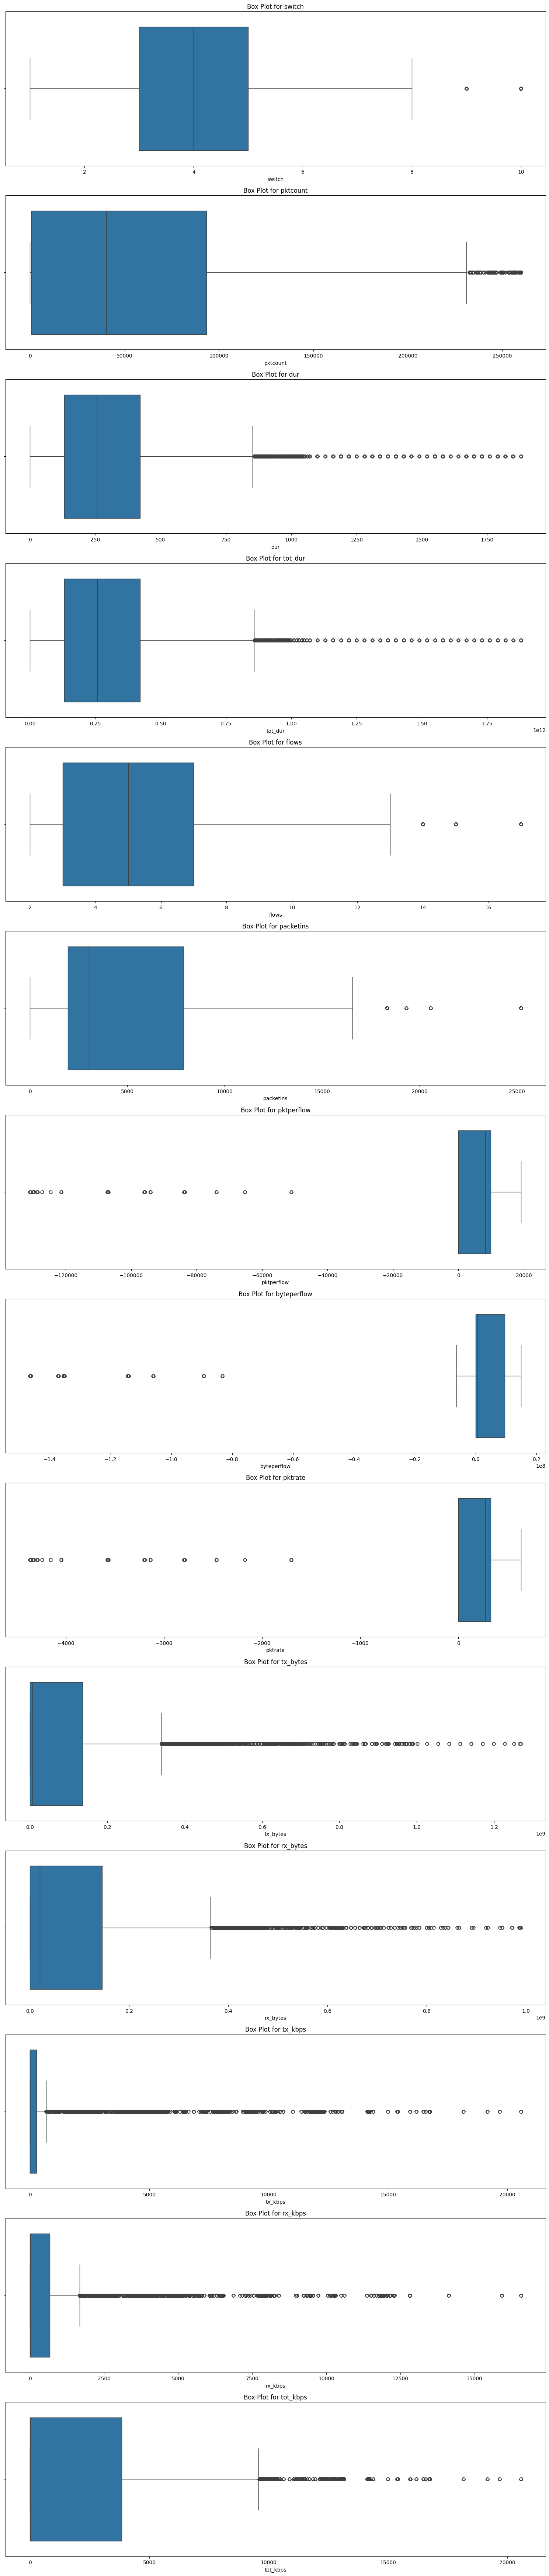

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def detect_outliers(df, columns):
    outlier_columns = [] 
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        if ((df[column] < lower_bound) | (df[column] > upper_bound)).any():
            outlier_columns.append(column)
    
    return outlier_columns

numeric_columns = df.select_dtypes(include=[np.number]).columns

# Detect columns with outliers
outlier_columns = detect_outliers(df, numeric_columns)

# Create box plots for columns with outliers
plt.figure(figsize=(15, len(outlier_columns) * 5))  # Adjust figure size based on the number of plots
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(len(outlier_columns), 1, i)
    sns.boxplot(x=df[column])
    plt.title(f"Box Plot for {column}")

plt.tight_layout()
plt.show()

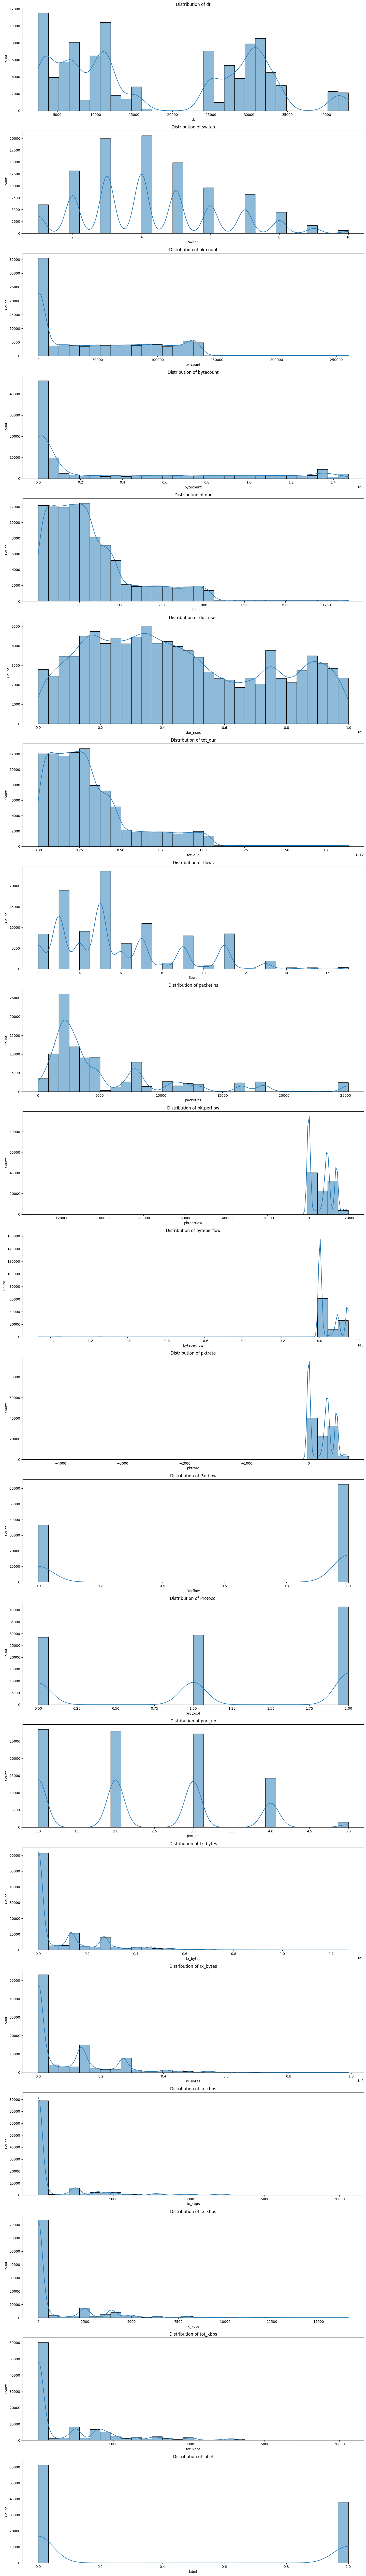

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Set figure size
plt.figure(figsize=(15, len(numeric_columns) * 5))

# Plot distribution for each numerical feature
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

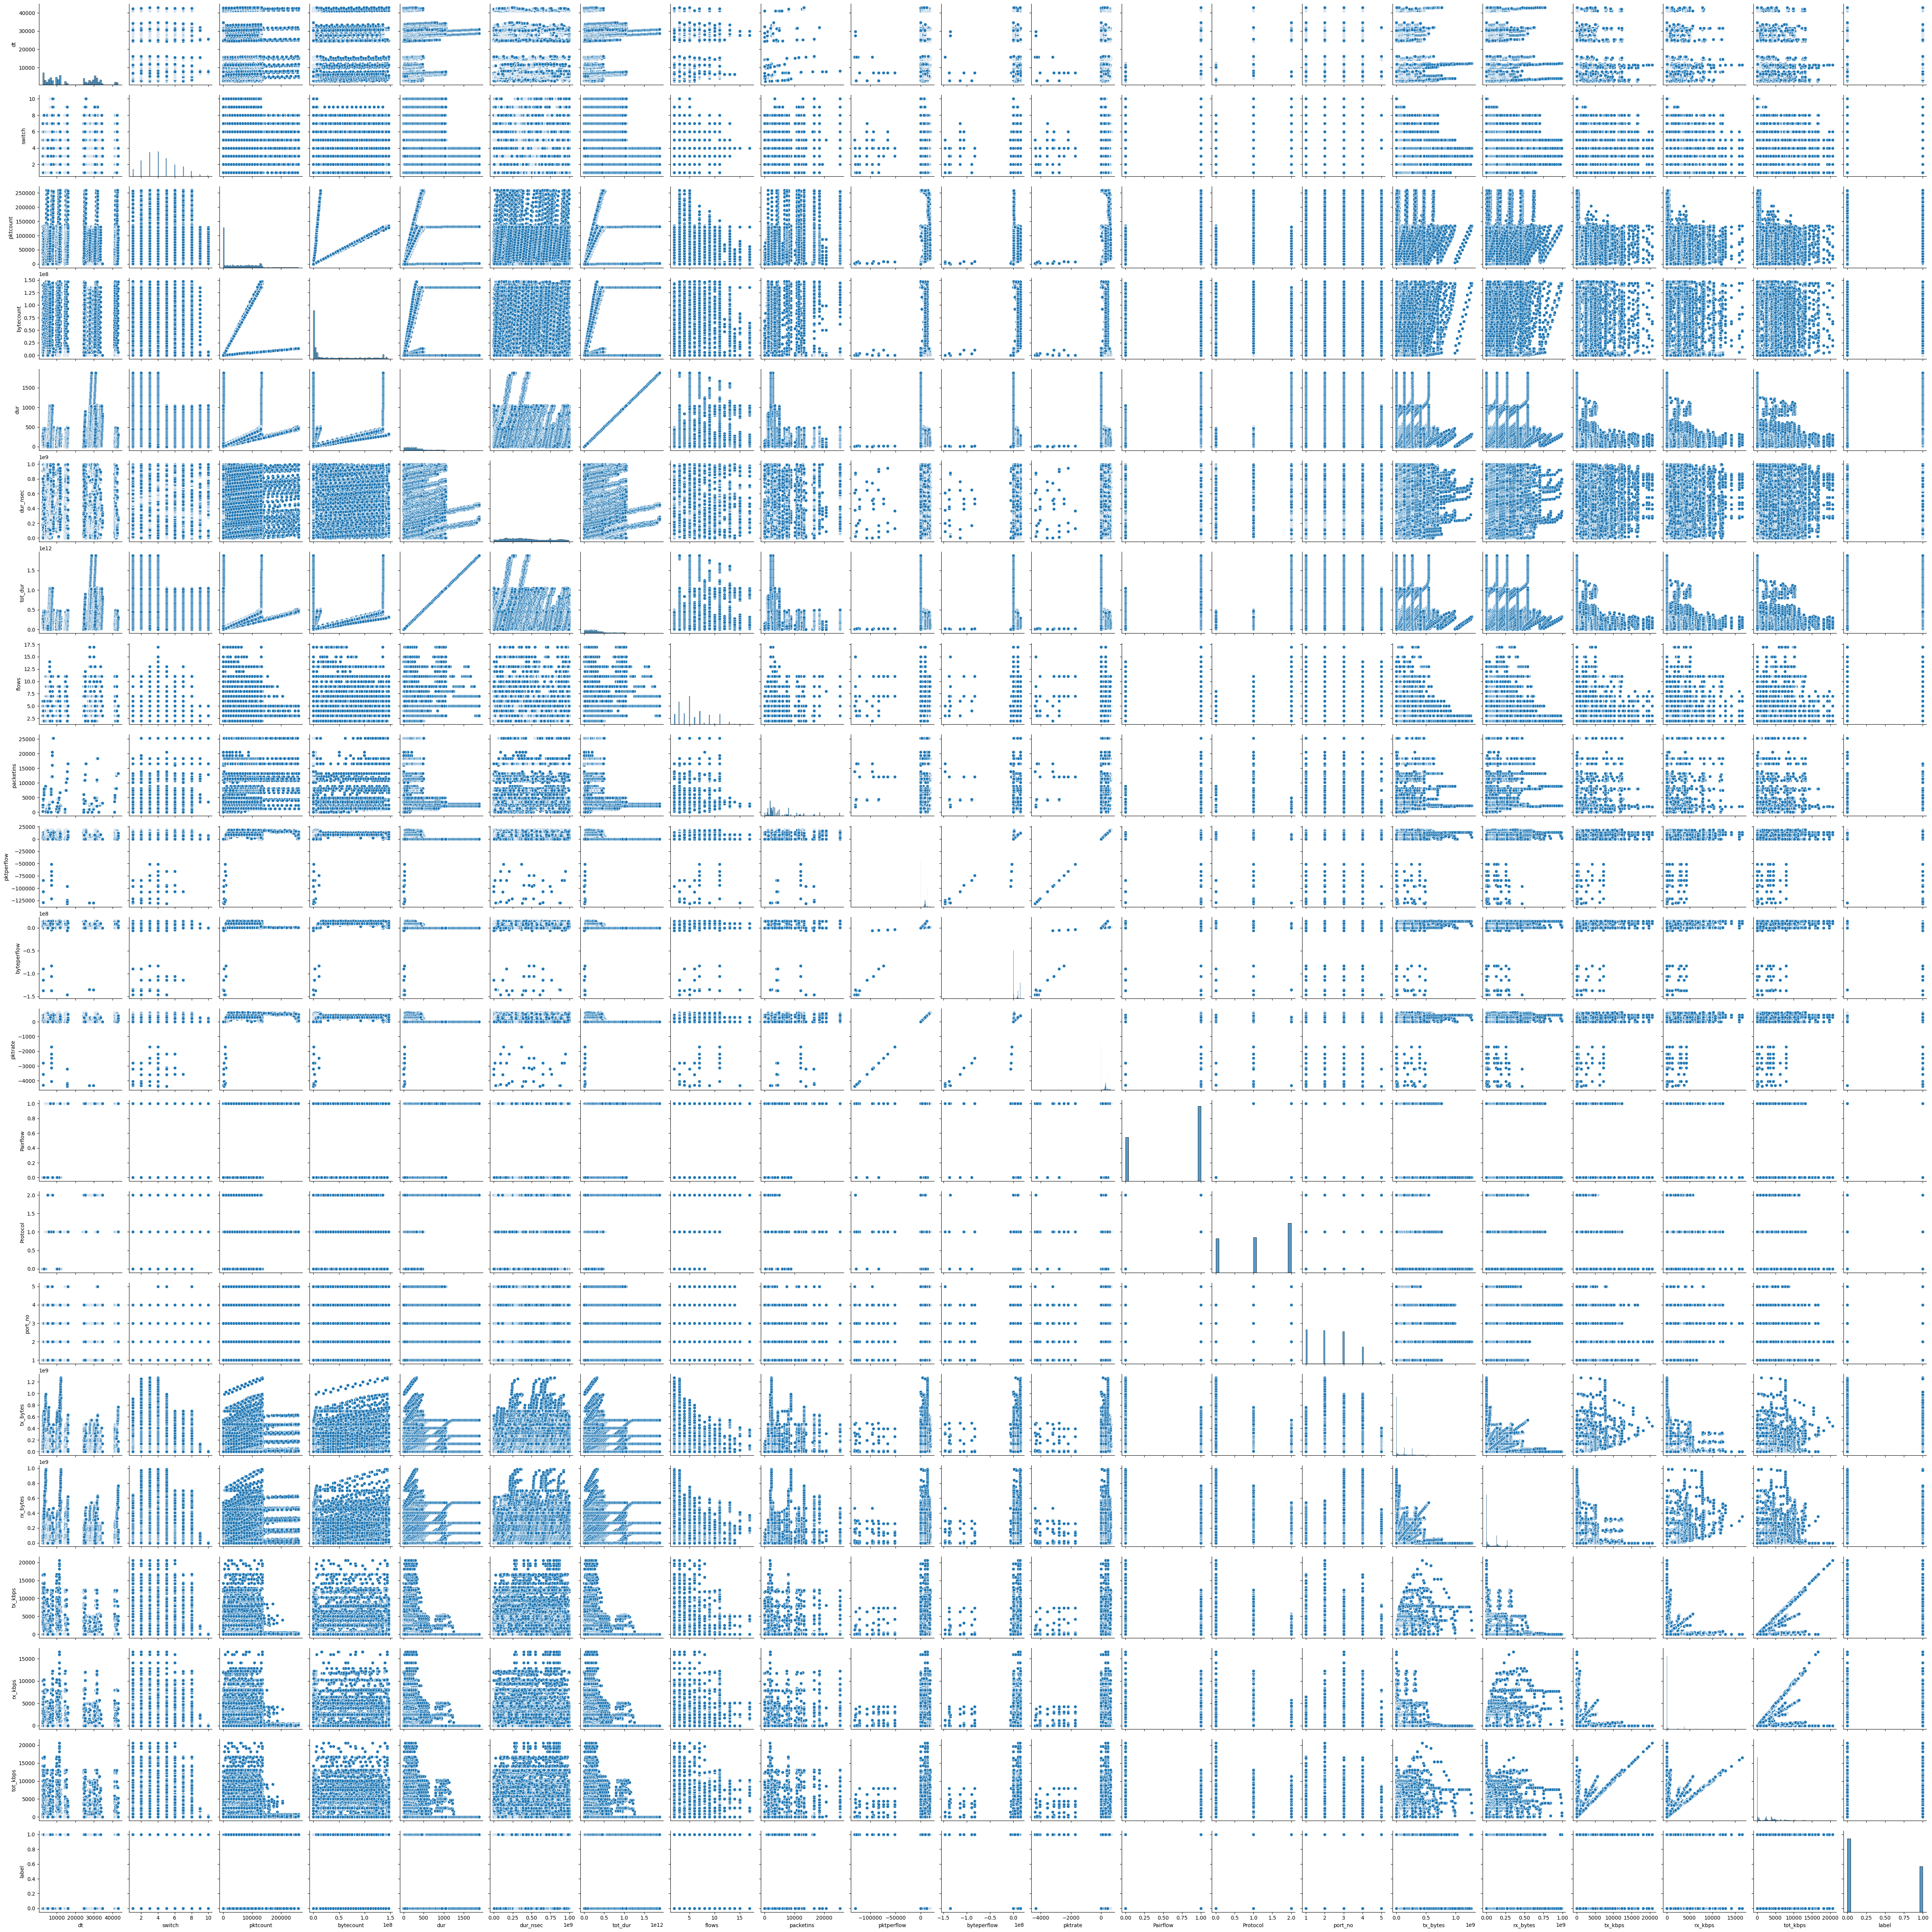

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bivariate visualization (pairplot)
sns.pairplot(df.select_dtypes(include=[np.number]))
plt.show()

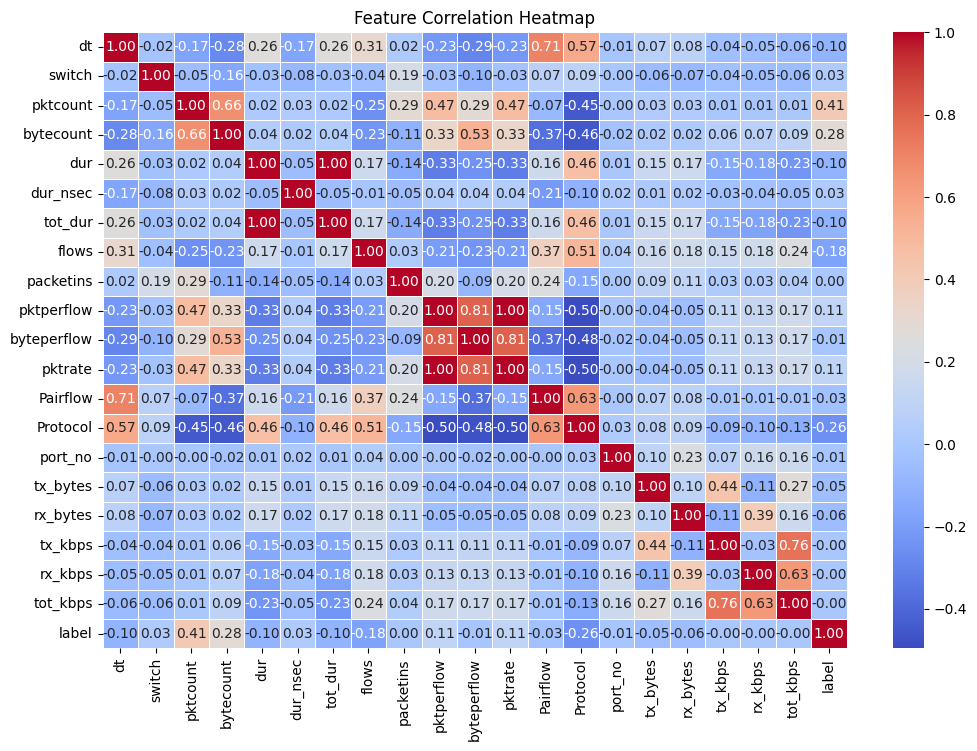

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [14]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Convert IP addresses to integers
def ip_to_int(ip):
    return int(ipaddress.IPv4Address(ip))

# Apply the transformation on the entire dataframe before splitting
df['src'] = df['src'].apply(ip_to_int)
df['dst'] = df['dst'].apply(ip_to_int)

# Select numerical columns for normalization
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Normalize the numerical columns using Min-Max Scaling
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features (X) and target (y)
X = df.drop(columns=['label'])  # Drop the target column
y = df['label']  # Target column

# Split into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Print the dataset sizes
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")

Training Set: (79403, 22), Testing Set: (19851, 22)


In [15]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     12306
         1.0       0.92      0.97      0.95      7545

    accuracy                           0.96     19851
   macro avg       0.95      0.96      0.96     19851
weighted avg       0.96      0.96      0.96     19851

Confusion Matrix:
[[11686   620]
 [  204  7341]]
